## Kmeans on odor stimulus reward trace data
In this notebook I run kmeans on smoothed trace data from the odor-stimulus-reward learning experiment. Preprocessing is based on Synchrony_all_mouse.ipynb. Data used is from a single mouse post learning the task. A single mouse was used because clustering across neurons from multiple mice would not make sense in this context, however as an extension the same analysis could be done on multiple mice and the clustering metrics compared.

The clustering is done such that each observation is a trial and each feature is a neuron whose value is the time within the trial where the trace was highest. For the sake of simplifying this analysis it is assumed that each trace has a single peak, which is not the case but applies the majority of the time. Consequently the procedure clusters trials where neurons consistently fire at similar times.

### Preprocessing

In [33]:
#rootdir ='c:\\Users\\noam\\Desktop\\mazen\\odor_ass_learning_2019\\' #noam
rootdir ='/media/data/DATA1/data/odor_ass_learning_2019/'            #lab change if necessary
import os
import sys
import numpy as np
import matplotlib as mp
import pylab as pl
from sklearn.cluster import KMeans
from scipy import stats as stats
sys.path.append(os.path.join(rootdir,'code'))
import utils as ut
import xml.etree.ElementTree as ET
from scipy.cluster import vq
from sklearn import metrics
from collections import Counter
%matplotlib inline
#global parameters
mouse ='c3m1'
datadir = os.path.join(rootdir,'results',mouse,'post','data')
CYCLE_START = -1  # seconds
CS_DURATION = 2  # seconds
DELAY = 2  # seconds
AFTER_DELAY_DURATION = 4  # seconds
CYCLE_DURATION = abs(CYCLE_START) + CS_DURATION + DELAY + AFTER_DELAY_DURATION

# loading traces
traces = np.loadtxt(os.path.join(datadir, 'C.txt')) #denoised traces
traces[np.isnan(traces)] = 0 #remove nans
# get time axis from xml file (as seen in notebook)
xmlfile = os.path.join(datadir, 'tseries.xml') 
tree = ET.parse(xmlfile);root = tree.getroot()
time_ax = np.r_[[child.attrib['absoluteTime'] for child in root.iter('Frame')]].astype(float)
# behavior codes
filename = os.path.join(datadir, 'behavior_codes.txt')
behavior = ut.read_behavior(filename)
# syncing behavior to trace time series
arduino_s = ut.parse_behavior(behavior, 'BEGIN')[0] #get start of first cycle
behavior = [[float(b[0])-arduino_s, b[1]] for b in behavior] #subtract so behavior starts at 0
time_ax -= time_ax[0] #start trace time at o
ratio = int(np.floor(time_ax.shape[0]/traces.shape[1])) #adjust time for xml so same number of time points as trace data
time_ax = time_ax[::ratio]
if time_ax.shape[0]!=traces.shape[1]:
    raise ValueError('tseries time and calcium dat time are not aligned')
behavior = ut.sync_behavior_to_xml(time_ax, behavior) #sync up times from
# get reward cycles
odor_rw_ons = ut.parse_behavior(behavior, 'TONE_RW', offset=CYCLE_START)#start times for cycles with reward
tdiff = np.median(np.diff(time_ax)) #median length of time step ~0.3s
cycle_dur_in_idxs = int(np.ceil(CYCLE_DURATION/tdiff)) #time of cycle converted to number of time steps
time_ax_transpose = time_ax.reshape(1,np.shape(time_ax)[0])    
i = 0 #remember python is 0-indexed
idxnpeakcyc = np.zeros((len(odor_rw_ons),traces.shape[0])) #time (in steps) of peak trace per neuron per trial
#for each cycle extract trace 
for i in range(0,len(odor_rw_ons)):
    tidxB = np.argwhere(time_ax>=odor_rw_ons[i])[0][0]  #time index (step) for start of cycle
    tidxE = tidxB+cycle_dur_in_idxs # '' for end of cycle
    traces_cyc = traces[:,tidxB:tidxE] # traces for cycle where each row is a different neuron
    traces_cyc[np.isnan(traces_cyc)]=0 # set nans to 0
    #since each neuron is being treated as a seperate feature in clustering no need to normalize on a per trace basis
    idxnpeakcyc[i,:] = np.argmax(traces_cyc,1) #get time step in cycle of max trace for each neuron 

### Kmeans clustering 
Clustering is run such that each trial/cycle is an observation and each neuron is a feature whose value is the time (in time step indices, 1 step ~ 0.3s) where the trace is highest. To find the optimal number of clusters, kmeans with `nclusters` is run `nrun` times, and the metrics are averaged.  

In [34]:
nclusters=[2,4,6,8,10,12,14,16,20,30] # number of centroids to try
nruns=20 # number of times to try
d=[]; inertia=[]; silhouette=[] #metrics (see below)
for i in range(0,len(nclusters)):
    a=[];b=[]; c=[]
    for j in range(0,nruns):
        a.append(j)
        km = KMeans(nclusters[i]).fit(vq.whiten(idxnpeakcyc)) #the whitening function normalizes data 
                    #on a per feauture basis by variance which improves the performance of clustering
        b.append(km.inertia_)
        c.append(metrics.silhouette_score(idxnpeakcyc,km.labels_))
    d.append(a);inertia.append(b);silhouette.append(c)
    print('kmeans on '+str(nclusters[i])+' clusters ')

kmeans on 2 clusters 
kmeans on 4 clusters 
kmeans on 6 clusters 
kmeans on 8 clusters 
kmeans on 10 clusters 
kmeans on 12 clusters 
kmeans on 14 clusters 
kmeans on 16 clusters 
kmeans on 20 clusters 
kmeans on 30 clusters 


The metrics used to quantify cluster performance here are inertia, which is a sum of the squared distance of each sample to the centroid of the cluster, and silhouette score which compares the mean distance of samples within a cluster to the distance of those in the nearest cluster.

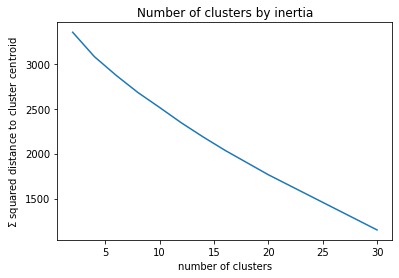

In [35]:
# Sum of squared distances of samples to their closest cluster center.
pl.plot(nclusters,np.mean(inertia,1))
pl.title('Number of clusters by inertia')
pl.xlabel('number of clusters')
pl.ylabel('$\Sigma$ squared distance to cluster centroid');

The plot of inertia is not highly informative in this case. Inertia decreasing at a constant rate could be an indication that the clustering is not very effective, and that the increase is solely due to incremental over-fitting.

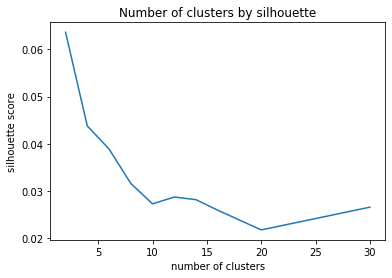

In [36]:
# distance to samples within cluster compared to those of nearest cluster
pl.plot(nclusters,np.mean(silhouette,1))
pl.title('Number of clusters by silhouette')
pl.xlabel('number of clusters')
pl.ylabel('silhouette score');

The silhouette score is more compelling in that there does seem to be an average local maximum possibly around 6 clusters (for the run when this notebook was written in at least), however the range of scores is low (close to 0), which could indicate that the clustering is not highly effective.

### Clusters
Based on the previous metrics, 6 clusters were used in the following results.

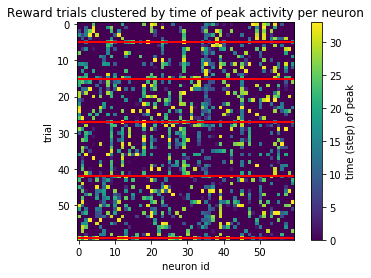

In [37]:
pl.clf()
km = KMeans(n_clusters=6).fit(idxnpeakcyc)
idxnpeakcyc_sorted = idxnpeakcyc[np.argsort(km.labels_),:] #sort data by kmeans cluster
pl.imshow(idxnpeakcyc_sorted)
c=pl.colorbar()
c.ax.set_ylabel('time (step) of peak')
pl.title('Reward trials clustered by time of peak activity per neuron')
pl.ylabel('trial'); pl.xlabel('neuron id')
edges = np.cumsum(list(Counter(np.sort(km.labels_)).values()))#number of trials in cluster
edges=edges[:-1] #last edge is redundant
pl.plot([0,59],[edges,edges],linewidth=2,color='r'); #60=number of neurons

The clustering results are shown per trial (y-axis) for each neuron (x-axis), where the color bar represents the time in the trial, and the red lines delineate cluster boundaries. The plot is counter intuitive in the sense that time is not displayed from left to right, but instead is represented by color. The interesting result here is neurons who maintain a constant, non-zero color throughout a cluster of trials (vertical rows with the same color), meaning they fire consistently at the same time across multiple trials. There are clearly some clusters that contain stable neurons such as these.

### Discussion and next steps
Although the metrics for kmeans in this configuration were not especially high, there do seem to be clusters of trials containing neurons with stable firing times. This needs to be further validated in the data, as I have not done any validation beyond the verifying code itself. Another addition I would have liked to include is a plot showing neurons arranged by firing time and relating the clusters to the stimuli, however since the peak firing times are inconsistent and  not unique across the neurons, this is not trivial and would take some thought. It would also be interesting to compare this stability prior to learning, which would be fairly straightforward. 

While this approach is good for finding neurons that consistently fire at similar times across trials, it does not do a good job of finding stable relationships between neurons, as well as stable relationships that are independent of absolute time (time in trial). A very compelling approach would be something like nearest neighbor, which could find not only absolute firing time relationships, including to stimulus and reward, but neurons that fire together consistently independent of trial time.

### Notes on the project
By far the most time-consuming part of this project was setting up Jupyter and an IDE to develop the code in. I would break down the time spent on this project as follows.

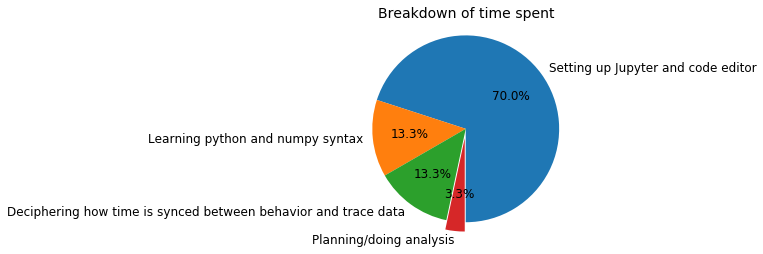

In [38]:
labels = 'Setting up Jupyter and code editor', 'Learning python and numpy syntax', \
'Deciphering how time is synced between behavior and trace data', 'Planning/doing analysis' 
sizes = [42, 8, 8, 2]
explode = (0, 0, 0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = pl.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        startangle=270, textprops={'fontsize': 12})
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
pl.title('Breakdown of time spent',  fontdict={'fontsize' : 14})
pl.show()

Coming from matlab I forgot how fragmented the open source world is. The next analysis should be more efficient.

-Noam